In [279]:
import requests


class BrightSky:

    def __init__(self):
        self.api_url = "https://api.brightsky.dev/weather?date={date}&last_date={last_date}&lat={lat}&lon={lon}"

    
    def get_weather(self, date, last_date, lat, lon):
        url = self.api_url.format(date=date, last_date=last_date, lat=lat, lon=lon)
        
        request = requests.get(url)

        return request.json()

In [286]:
from datetime import datetime, timedelta
import pytz


data_retreiver = BrightSky()
start_date = datetime.now(pytz.timezone('Europe/Berlin'))
end_date = start_date + timedelta(hours=12)
lat = 54.11
lon = 12.14
number_of_size_steps = 10
step_size = 0.1

weather_data = {}
searched_locations = 0

for lat_offset in range(-number_of_size_steps // 2, number_of_size_steps // 2):
    for lon_offset in range(-number_of_size_steps // 2, number_of_size_steps // 2):
        latitude = lat + (lat_offset * step_size)
        longitude = lon + (lon_offset * step_size)

        latitude = round(latitude, 2)
        longitude = round(longitude, 2)

        searched_locations += 1

        print(f"{searched_locations}: Getting data for {latitude}, {longitude} for {start_date.__format__('%d.%m.%Y %H:%M:%S')} to {end_date.__format__('%d.%m.%Y %H:%M:%S')}")

        data = data_retreiver.get_weather(start_date.isoformat(), end_date.isoformat(), latitude, longitude)

        for entry in data['weather']:
            time = entry['timestamp']
            cloud_coverage = entry['cloud_cover']

            if not time in weather_data:
                weather_data[time] = {}
            
            weather_data[time][(latitude, longitude)] = cloud_coverage

1: Getting data for 53.61, 11.64 for 09.05.2024 21:23:11 to 10.05.2024 09:23:11
2: Getting data for 53.61, 11.74 for 09.05.2024 21:23:11 to 10.05.2024 09:23:11
3: Getting data for 53.61, 11.84 for 09.05.2024 21:23:11 to 10.05.2024 09:23:11
4: Getting data for 53.61, 11.94 for 09.05.2024 21:23:11 to 10.05.2024 09:23:11
5: Getting data for 53.61, 12.04 for 09.05.2024 21:23:11 to 10.05.2024 09:23:11
6: Getting data for 53.61, 12.14 for 09.05.2024 21:23:11 to 10.05.2024 09:23:11
7: Getting data for 53.61, 12.24 for 09.05.2024 21:23:11 to 10.05.2024 09:23:11
8: Getting data for 53.61, 12.34 for 09.05.2024 21:23:11 to 10.05.2024 09:23:11
9: Getting data for 53.61, 12.44 for 09.05.2024 21:23:11 to 10.05.2024 09:23:11
10: Getting data for 53.61, 12.54 for 09.05.2024 21:23:11 to 10.05.2024 09:23:11
11: Getting data for 53.71, 11.64 for 09.05.2024 21:23:11 to 10.05.2024 09:23:11
12: Getting data for 53.71, 11.74 for 09.05.2024 21:23:11 to 10.05.2024 09:23:11
13: Getting data for 53.71, 11.84 for

In [287]:
import pprint

clouds_cover_over_time = {}

for time in weather_data:
    clouds_cover_over_time[time] = []

    for lat_offset in range(number_of_size_steps // 2, -number_of_size_steps // 2, -1):
        latitude = lat + ((lat_offset - 1) * step_size)

        clouds_cover_over_time[time].insert(0, [clouds for location, clouds in weather_data[time].items() if location[0] == latitude])

pprint.pprint(clouds_cover_over_time)

{'2024-05-09T22:00:00+02:00': [[94, 97, 98, 98, 100, 100, 100, 100, 100, 100],
                               [95, 95, 98, 98, 100, 100, 100, 100, 100, 100],
                               [95, 98, 98, 98, 97, 98, 98, 86, 100, 100],
                               [96, 96, 98, 98, 97, 99, 86, 99, 99, 82],
                               [96, 96, 96, 98, 91, 99, 99, 100, 100, 82],
                               [95, 96, 92, 92, 91, 91, 100, 100, 100, 82],
                               [97, 97, 97, 98, 98, 98, 95, 95, 95, 95],
                               [97, 97, 97, 97, 98, 95, 95, 95, 95, 95],
                               [97, 97, 97, 97, 95, 97, 97, 97, 96, 87],
                               [100, 97, 97, 97, 97, 97, 97, 97, 97, 96]],
 '2024-05-09T23:00:00+02:00': [[92, 94, 97, 97, 99, 99, 99, 100, 100, 100],
                               [98, 98, 97, 97, 99, 99, 99, 100, 100, 100],
                               [98, 100, 100, 100, 100, 100, 100, 99, 100, 100],
                

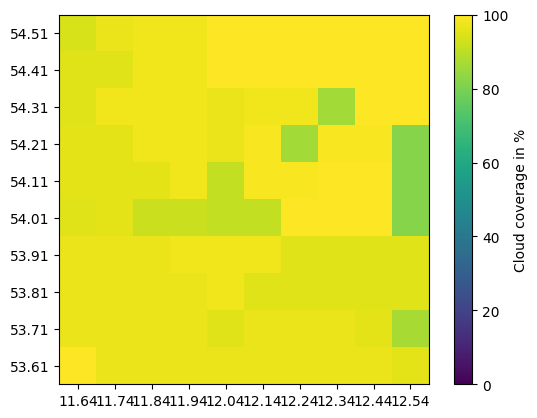

In [288]:
import matplotlib.pyplot as plt
import matplotlib as mpl


time = list(clouds_cover_over_time.keys())[0]

x_labels = [(lon + ((x - number_of_size_steps // 2) / 10)) for x in range(number_of_size_steps)]
y_labels = [(lat + ((y - number_of_size_steps // 2) / 10)) for y in range(number_of_size_steps)]

x_labels = [round(x, 2) for x in x_labels]
y_labels = [round(y, 2) for y in y_labels]
y_labels.reverse()

fig, ax = plt.subplots()

fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 100)), ax=ax, orientation='vertical', label='Cloud coverage in %')

im = ax.imshow(clouds_cover_over_time[time], vmin=0, vmax=100)

ax.set_xticks(range(number_of_size_steps), x_labels)
ax.set_yticks(range(number_of_size_steps), y_labels)

plt.show()

fig.frameon = False
ax.axis('off')
fig.savefig('clouds.png', bbox_inches='tight', pad_inches=0, dpi=300, transparent=True, format='png')

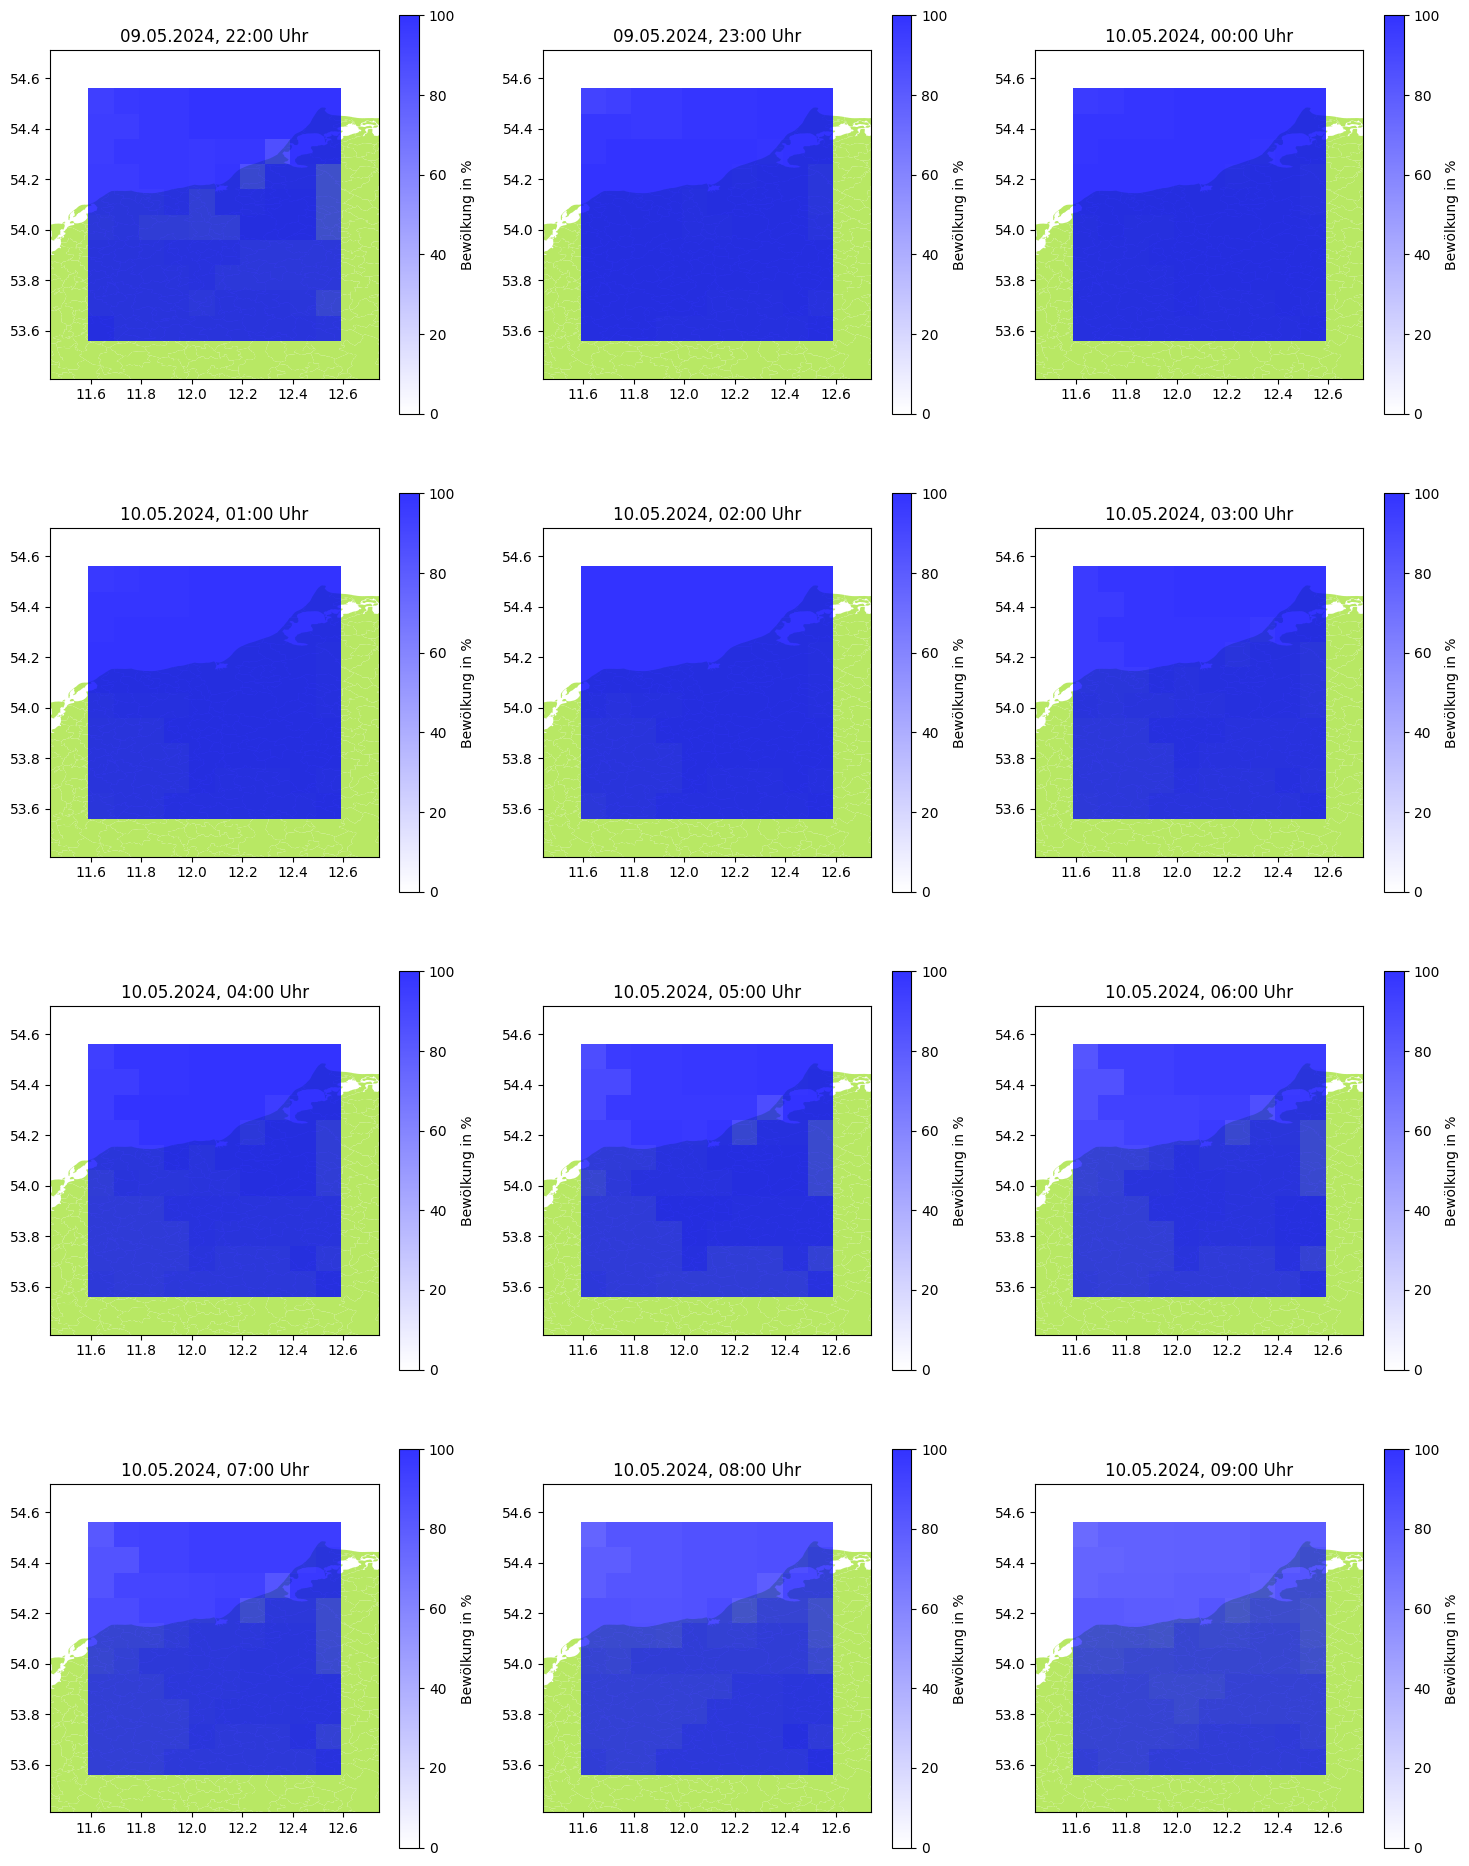

In [294]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


worldmap = geopandas.read_file('./shapefiles/gadm41_DEU_4.shp')

number_of_keys = len(clouds_cover_over_time.keys())
number_of_cols = 3
number_of_rows = number_of_keys // number_of_cols + 1

fig = plt.figure(figsize=(6 * number_of_cols, 6 * number_of_rows))

for entry, data in clouds_cover_over_time.items():
    index = list(clouds_cover_over_time.keys()).index(entry)
    
    ax = fig.add_subplot(number_of_rows, 3, index + 1)

    worldmap.plot(ax = ax, color='#b8e864')

    df = pd.DataFrame(data, columns=x_labels, index=y_labels)

    x = df.columns
    y = df.index
    z = df.values

    colors = [(0, 0, 1, a) for a in np.linspace(0, 0.8, 256)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', colors)
    c = ax.pcolormesh(x, y, z, cmap=cmap, shading='auto', vmin=0, vmax=100)

    date = datetime.fromisoformat(entry)
    ax.set_title(date.__format__('%d.%m.%Y, %H:%M Uhr'))
    ax.set_ylim(min(y) - 0.2, max(y) + 0.2)
    ax.set_xlim(min(x) - 0.2, max(x) + 0.2)

    fig.colorbar(c, ax=ax, orientation='vertical', label='Bewölkung in %')
    
plt.savefig('clouds_over_time.png', dpi=300, transparent=False, format='png')